# Semi-Supervised Propagation (SSP) for Graph Neural Networks
This notebook implements the Semi-Supervised Propagation (SSP) approach for Graph Neural Networks as described in the ssp paper. The implementation includes:

### Key Components
1. Modified GCN Layer: Enhanced Graph Convolutional Network layer with proper normalization and caching
2. K-FAC Optimizer: Kronecker-factored approximate curvature optimization for efficient training
3. SSP Architecture: Complete model combining convolutional representation learning with semi-supervised propagation


## Code source
https://github.com/russellizadi/ssp

In [23]:
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
from torch.optim.optimizer import Optimizer
from torch_scatter import scatter
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [24]:
# NOTE: This is just bug fix from PR

from typing import Optional, Tuple
from torch_geometric.typing import Adj, OptTensor, PairTensor
import torch
from torch import Tensor
from torch.nn import Parameter
from torch_scatter import scatter_add
from torch_sparse import SparseTensor, matmul, fill_diag, sum, mul_
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import add_remaining_self_loops
from torch_geometric.utils.num_nodes import maybe_num_nodes
import math

def glorot(tensor):
    if tensor is not None:
        stdv = math.sqrt(6.0 / (tensor.size(-2) + tensor.size(-1)))
        tensor.data.uniform_(-stdv, stdv)

def zeros(tensor):
    if tensor is not None:
        tensor.data.fill_(0)

@torch.jit._overload
def gcn_norm(edge_index, edge_weight=None, num_nodes=None, improved=False,
             add_self_loops=True, dtype=None):
    # type: (Tensor, OptTensor, Optional[int], bool, bool, Optional[int]) -> PairTensor  # noqa
    pass
@torch.jit._overload
def gcn_norm(edge_index, edge_weight=None, num_nodes=None, improved=False,
             add_self_loops=True, dtype=None):
    # type: (SparseTensor, OptTensor, Optional[int], bool, bool, Optional[int]) -> SparseTensor  # noqa
    pass
def gcn_norm(edge_index, edge_weight=None, num_nodes=None, improved=False,
             add_self_loops=True, dtype=None):
    fill_value = 2. if improved else 1.
    if isinstance(edge_index, SparseTensor):
        adj_t = edge_index
        if not adj_t.has_value():
            adj_t.fill_value(1., dtype=dtype)
        if add_self_loops:
            adj_t = fill_diag(adj_t, fill_value)
        deg = sum(adj_t, dim=1)
        deg_inv_sqrt = deg.pow_(-0.5)
        deg_inv_sqrt.masked_fill_(deg_inv_sqrt == float('inf'), 0.)
        adj_t = mul_(adj_t, deg_inv_sqrt.view(-1, 1))
        adj_t = mul_(adj_t, deg_inv_sqrt.view(1, -1))
        return adj_t
    else:
        num_nodes = maybe_num_nodes(edge_index, num_nodes)
        if edge_weight is None:
            edge_weight = torch.ones((edge_index.size(1), ), dtype=dtype,
                                     device=edge_index.device)
        if add_self_loops:
            edge_index, tmp_edge_weight = add_remaining_self_loops(
                edge_index, edge_weight, fill_value, num_nodes)
            assert tmp_edge_weight is not None
            edge_weight = tmp_edge_weight
        row, col = edge_index[0], edge_index[1]
        deg = scatter_add(edge_weight, col, dim=0, dim_size=num_nodes)
        deg_inv_sqrt = deg.pow_(-0.5)
        deg_inv_sqrt.masked_fill_(deg_inv_sqrt == float('inf'), 0)
        return edge_index, deg_inv_sqrt[row] * edge_weight * deg_inv_sqrt[col]
class GCNConvFix(MessagePassing):
    r"""The graph convolutional operator from the `"Semi-supervised
    Classification with Graph Convolutional Networks"
    <https://arxiv.org/abs/1609.02907>`_ paper
    .. math::
        \mathbf{X}^{\prime} = \mathbf{\hat{D}}^{-1/2} \mathbf{\hat{A}}
        \mathbf{\hat{D}}^{-1/2} \mathbf{X} \mathbf{\Theta},
    where :math:`\mathbf{\hat{A}} = \mathbf{A} + \mathbf{I}` denotes the
    adjacency matrix with inserted self-loops and
    :math:`\hat{D}_{ii} = \sum_{j=0} \hat{A}_{ij}` its diagonal degree matrix.
    Args:
        in_channels (int): Size of each input sample.
        out_channels (int): Size of each output sample.
        improved (bool, optional): If set to :obj:`True`, the layer computes
            :math:`\mathbf{\hat{A}}` as :math:`\mathbf{A} + 2\mathbf{I}`.
            (default: :obj:`False`)
        cached (bool, optional): If set to :obj:`True`, the layer will cache
            the computation of :math:`\mathbf{\hat{D}}^{-1/2} \mathbf{\hat{A}}
            \mathbf{\hat{D}}^{-1/2}` on first execution, and will use the
            cached version for further executions.
            This parameter should only be set to :obj:`True` in transductive
            learning scenarios. (default: :obj:`False`)
        normalize (bool, optional): Whether to add self-loops and apply
            symmetric normalization. (default: :obj:`True`)
        add_self_loops (bool, optional): If set to :obj:`False`, will not add
            self-loops to the input graph. (default: :obj:`True`)
        bias (bool, optional): If set to :obj:`False`, the layer will not learn
            an additive bias. (default: :obj:`True`)
        **kwargs (optional): Additional arguments of
            :class:`torch_geometric.nn.conv.MessagePassing`.
    """

    _cached_edge_index: Optional[Tuple[torch.Tensor, torch.Tensor]]
    _cached_edge_index: Optional[Tuple[Tensor, Tensor]]
    _cached_adj_t: Optional[SparseTensor]

    def __init__(self, in_channels: int, out_channels: int,
                 improved: bool = False, cached: bool = False,
                 add_self_loops: bool = True, normalize: bool = True,
                 bias: bool = True, **kwargs):
        super(GCNConvFix, self).__init__(aggr='add', **kwargs)
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.improved = improved
        self.cached = cached
        self.normalize = normalize
        self.add_self_loops = add_self_loops
        self._cached_edge_index = None
        self._cached_adj_t = None
        self.weight = Parameter(torch.Tensor(in_channels, out_channels))
        if bias:
            self.bias = Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()
    def reset_parameters(self):
        glorot(self.weight)
        zeros(self.bias)
        self._cached_edge_index = None
        self._cached_adj_t = None
    def forward(self, x: Tensor, edge_index: Adj,
                edge_weight: OptTensor = None) -> Tensor:
        """"""
        if self.normalize:
            if isinstance(edge_index, Tensor):
                cache = self._cached_edge_index
                if cache is None:
                    edge_index, edge_weight = gcn_norm(  # yapf: disable
                        edge_index, edge_weight, x.size(self.node_dim),
                        self.improved, self.add_self_loops, dtype=x.dtype)
                    if self.cached:
                        self._cached_edge_index = (edge_index, edge_weight)
                else:
                    edge_index, edge_weight = cache[0], cache[1]
            elif isinstance(edge_index, SparseTensor):
                cache = self._cached_adj_t
                if cache is None:
                    edge_index = gcn_norm(  # yapf: disable
                        edge_index, edge_weight, x.size(self.node_dim),
                        self.improved, self.add_self_loops, dtype=x.dtype)
                    if self.cached:
                        self._cached_adj_t = edge_index
                else:
                    edge_index = cache
        x = torch.matmul(x, self.weight)
        # propagate_type: (x: Tensor, edge_weight: OptTensor)
        out = self.propagate(edge_index, x=x, edge_weight=edge_weight,
                             size=None)
        if self.bias is not None:
            out += self.bias
        return out
    def message(self, x_j: Tensor, edge_weight: Tensor) -> Tensor:
        return edge_weight.view(-1, 1) * x_j
    def message_and_aggregate(self, adj_t: SparseTensor, x: Tensor) -> Tensor:
        return matmul(adj_t, x, reduce=self.aggr)
    def __repr__(self):
        return '{}({}, {})'.format(self.__class__.__name__, self.in_channels,
                                   self.out_channels)

# K-FAC (Kronecker-Factored Approximate Curvature) Optimizer
This implements the K-FAC optimization algorithm adapted for graph neural networks. Key features:
- Maintains running estimates of the Fisher Information Matrix
- Uses Kronecker-factored approximation for efficient computation
- Supports SUA (Spatially Uncorrelated Activations) approximation
- Includes options for Tikhonov regularization and pi correction

In [25]:
class KFAC(Optimizer):
    #source: https://github.com/russellizadi/ssp/blob/master/experiments/psgd.py
    def __init__(self, net, eps, sua=False, pi=False, update_freq=1,
                 alpha=1.0, constraint_norm=False):
        """ K-FAC Preconditionner for Linear and Conv2d layers.
        Computes the K-FAC of the second moment of the gradients.
        It works for Linear and Conv2d layers and silently skip other layers.
        Args:
            net (torch.nn.Module): Network to precondition.
            eps (float): Tikhonov regularization parameter for the inverses.
            sua (bool): Applies SUA approximation.
            pi (bool): Computes pi correction for Tikhonov regularization.
            update_freq (int): Perform inverses every update_freq updates.
            alpha (float): Running average parameter (if == 1, no r. ave.).
            constraint_norm (bool): Scale the gradients by the squared
                fisher norm.
        """

        self.eps = eps
        self.sua = sua
        self.pi = pi
        self.update_freq = update_freq
        self.alpha = alpha
        self.constraint_norm = constraint_norm
        self.params = []
        self._fwd_handles = []
        self._bwd_handles = []
        self._iteration_counter = 0
        
        for mod in net.modules():
            mod_name = mod.__class__.__name__
            if mod_name in ['CRD', 'CLS']:
                handle = mod.register_forward_pre_hook(self._save_input)
                self._fwd_handles.append(handle)
                
                for sub_mod in mod.modules():
                    i_sub_mod = 0
                    if hasattr(sub_mod, 'weight'):
                        assert i_sub_mod == 0
                        handle = sub_mod.register_backward_hook(self._save_grad_output)
                        self._bwd_handles.append(handle)
                        
                        params = [sub_mod.weight]
                        if sub_mod.bias is not None:
                            params.append(sub_mod.bias)

                        d = {'params': params, 'mod': mod, 'sub_mod': sub_mod}
                        self.params.append(d)
                        i_sub_mod += 1

        super(KFAC, self).__init__(self.params, {})

    def step(self, update_stats=True, update_params=True, lam=0.):
        """Performs one step of preconditioning."""
        self.lam = lam
        fisher_norm = 0.
        for group in self.param_groups:
            
            if len(group['params']) == 2:
                weight, bias = group['params']
            else:
                weight = group['params'][0]
                bias = None
            state = self.state[weight]

            # Update convariances and inverses
            if update_stats:
                if self._iteration_counter % self.update_freq == 0:
                    self._compute_covs(group, state)
                    ixxt, iggt = self._inv_covs(state['xxt'], state['ggt'],
                                                state['num_locations'])
                    state['ixxt'] = ixxt
                    state['iggt'] = iggt
                else:
                    if self.alpha != 1:
                        self._compute_covs(group, state)

            if update_params:
                gw, gb = self._precond(weight, bias, group, state)

                # Updating gradients
                if self.constraint_norm:
                    fisher_norm += (weight.grad * gw).sum()

                weight.grad.data = gw
                if bias is not None:
                    if self.constraint_norm:
                        fisher_norm += (bias.grad * gb).sum()
                    bias.grad.data = gb
                    
            # Cleaning
            if 'x' in self.state[group['mod']]:
                del self.state[group['mod']]['x']
            if 'gy' in self.state[group['mod']]:
                del self.state[group['mod']]['gy']
        
        # Eventually scale the norm of the gradients
        if update_params and self.constraint_norm:
            scale = (1. / fisher_norm) ** 0.5
            for group in self.param_groups:
                for param in group['params']:
                    print(param.shape, param)
                    param.grad.data *= scale

        if update_stats:
            self._iteration_counter += 1

    def _save_input(self, mod, i):
        """Saves input of layer to compute covariance."""
        # i = (x, edge_index)
        if mod.training:
            self.state[mod]['x'] = i[0]
            
            self.mask = i[-1]
            
    def _save_grad_output(self, mod, grad_input, grad_output):
        """Saves grad on output of layer to compute covariance."""
        if mod.training:
            self.state[mod]['gy'] = grad_output[0] * grad_output[0].size(1)
            self._cached_edge_index = mod._cached_edge_index

    def _precond(self, weight, bias, group, state):
        """Applies preconditioning."""
        ixxt = state['ixxt'] # [d_in x d_in]
        iggt = state['iggt'] # [d_out x d_out]
        g = weight.grad.data # [d_in x d_out]
        s = g.shape

        g = g.contiguous().view(-1, g.shape[-1])
            
        if bias is not None:
            gb = bias.grad.data
            g = torch.cat([g, gb.view(1, gb.shape[0])], dim=0)

        g = torch.mm(ixxt, torch.mm(g, iggt))
        if bias is not None:
            gb = g[-1].contiguous().view(*bias.shape)
            g = g[:-1]
        else:
            gb = None
        g = g.contiguous().view(*s)
        return g, gb

    def _compute_covs(self, group, state):
        """Computes the covariances."""
        sub_mod = group['sub_mod']
        x = self.state[group['mod']]['x'] # [n x d_in]
        gy = self.state[group['sub_mod']]['gy'] # [n x d_out]
        edge_index, edge_weight = self._cached_edge_index # [2, n_edges], [n_edges]
        
        n = float(self.mask.sum() + self.lam*((~self.mask).sum()))

        x = scatter(x[edge_index[0]]*edge_weight[:, None], edge_index[1], dim=0)
        
        x = x.data.t()

        if sub_mod.weight.ndim == 3:
            x = x.repeat(sub_mod.weight.shape[0], 1)
        


        if sub_mod.bias is not None:
            ones = torch.ones_like(x[:1])
            x = torch.cat([x, ones], dim=0)

        if self._iteration_counter == 0:
            state['xxt'] = torch.mm(x, x.t()) / n
        else:
            state['xxt'].addmm_(mat1=x, mat2=x.t(),
                                beta=(1. - self.alpha),
                                alpha=self.alpha / n)
        
        gy = gy.data.t() # [d_out x n]

        state['num_locations'] = 1
        if self._iteration_counter == 0:
            state['ggt'] = torch.mm(gy, gy.t()) / n 
        else:
            state['ggt'].addmm_(mat1=gy, mat2=gy.t(),
                                beta=(1. - self.alpha),
                                alpha=self.alpha / n)

    def _inv_covs(self, xxt, ggt, num_locations):
        """Inverses the covariances."""
        # Computes pi
        pi = 1.0
        if self.pi:
            tx = torch.trace(xxt) * ggt.shape[0]
            tg = torch.trace(ggt) * xxt.shape[0]
            pi = (tx / tg)
        # Regularizes and inverse
        eps = self.eps / num_locations
        diag_xxt = xxt.new(xxt.shape[0]).fill_((eps * pi) ** 0.5)
        diag_ggt = ggt.new(ggt.shape[0]).fill_((eps / pi) ** 0.5)
        ixxt = (xxt + torch.diag(diag_xxt)).inverse()
        iggt = (ggt + torch.diag(diag_ggt)).inverse()

        return ixxt, iggt

    def __del__(self):
        for handle in self._fwd_handles + self._bwd_handles:
            handle.remove()

In [26]:
def calculate_roc_auc(outputs, targets):
    """Calculate ROC-AUC score for multi-class"""
    probs = F.softmax(outputs, dim=1).cpu().numpy()
    targets = targets.cpu().numpy()
    n_classes = probs.shape[1]
    
    # One-vs-Rest ROC-AUC
    auc_scores = []
    for i in range(n_classes):
        y_true = (targets == i).astype(int)
        y_score = probs[:, i]
        fpr, tpr, _ = roc_curve(y_true, y_score)
        auc_scores.append(auc(fpr, tpr))
    
    return np.mean(auc_scores)


def plot_training_metrics(train_losses, val_losses, train_aucs, val_aucs):
    """Plot training metrics"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss plot
    ax1.plot(train_losses, label='Train Loss')
    ax1.plot(val_losses, label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    
    # ROC-AUC plot
    ax2.plot(train_aucs, label='Train ROC-AUC')
    ax2.plot(val_aucs, label='Validation ROC-AUC')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('ROC-AUC')
    ax2.set_title('Training and Validation ROC-AUC')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()


def visualize_embeddings(model, data, title):
    model.eval()
    with torch.no_grad():
        logits = model(data)
        embeddings = logits.cpu().numpy()

    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(embeddings)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=data.y.cpu().numpy(), cmap="tab10", s=10)
    plt.colorbar(scatter, label="Node Class")
    plt.title(title)
    plt.ylim(-10, 15)
    plt.show()

# Semi-Supervised Propagation (SSP) Model Architecture
The model consists of three main components:
1. CRD (Convolutional Representation Decoder): Initial GCN layer with ReLU and dropout
2. CLS (Classification Layer): Final GCN layer with softmax for classification
3. SSP: Combines CRD and CLS into a complete semi-supervised learning model

In [27]:
hidden_channels = 16
dropout_rate = 0.5


class CRD(torch.nn.Module):
    def __init__(self, d_in, d_out, p):
        super(CRD, self).__init__()
        self.conv = GCNConvFix(d_in, d_out, cached=True)  # Note: cached=True
        self.p = p
    
    def reset_parameters(self):
        self.conv.reset_parameters()

    def forward(self, x, edge_index, mask=None):  # Added mask parameter
        x = F.relu(self.conv(x, edge_index))
        x = F.dropout(x, p=self.p, training=self.training)
        return x

class CLS(torch.nn.Module):
    def __init__(self, d_in, d_out):
        super(CLS, self).__init__()
        self.conv = GCNConvFix(d_in, d_out, cached=True)  # Note: cached=True

    def reset_parameters(self):
        self.conv.reset_parameters()
    
    def forward(self, x, edge_index, mask=None):  # Added mask parameter
        x = self.conv(x, edge_index)
        x = F.log_softmax(x, dim=1)
        return x

class SSP(torch.nn.Module):
    def __init__(self, dataset):
        super(SSP, self).__init__()
        self.crd = CRD(dataset.num_features, hidden_channels, dropout_rate)
        self.cls = CLS(hidden_channels, dataset.num_classes)
    
    def reset_parameters(self):
        self.crd.reset_parameters()
        self.cls.reset_parameters()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.crd(x, edge_index)
        x = self.cls(x, edge_index)
        return x

    def get_embeddings(self, data):
        """Get the intermediate embeddings from CRD layer"""
        x, edge_index = data.x, data.edge_index
        return self.crd(x, edge_index)

In [36]:
import time
import torch
import torch.nn.functional as F
from torch import tensor
from torch_geometric.datasets import Planetoid

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def train(model, optimizer, data, preconditioner=None, lam=0.):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    label = out.max(1)[1]
    label[data.train_mask] = data.y[data.train_mask]
    label.requires_grad = False
    
    loss = F.nll_loss(out[data.train_mask], label[data.train_mask])
    loss += lam * F.nll_loss(out[~data.train_mask], label[~data.train_mask])
    
    loss.backward(retain_graph=True)
    if preconditioner:
        preconditioner.step(lam=lam)
    optimizer.step()

    return loss, out

def evaluate(model, data):
    model.eval()
    with torch.no_grad():
        logits = model(data)

    outs = {}
    for key in ['train', 'val', 'test']:
        mask = data['{}_mask'.format(key)]
        loss = F.nll_loss(logits[mask], data.y[mask]).item()
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()

        outs['{} loss'.format(key)] = loss
        outs['{} acc'.format(key)] = acc

    return outs

def run_training(
    dataset, 
    model,
    optimizer_name='Adam',
    preconditioner_name=None,
    runs=10,
    epochs=200,
    lr=0.01,
    weight_decay=5e-4,
    early_stopping=10,
    momentum=0.9,
    eps=0.01,
    update_freq=1,
    gamma=None,
    alpha=None
    ):
    
    accs, durations, train_losses, val_losses, train_aucs, val_aucs = [], [], [], [], [], []
    torch.manual_seed(42)
    

    for i_run in range(runs):
        data = dataset[0]
        data = data.to(device)

        model.to(device).reset_parameters()
        
        if preconditioner_name == 'KFAC':
            preconditioner = KFAC(
                model, 
                eps, 
                sua=False, 
                pi=False, 
                update_freq=update_freq,
                alpha=alpha if alpha is not None else 1.,
                constraint_norm=False
            )
        else: 
            preconditioner = None

        if optimizer_name == 'Adam':
            optimizer = torch.optim.Adam(
                model.parameters(), 
                lr=lr, 
                weight_decay=weight_decay
            )
        elif optimizer_name == 'SGD':
            optimizer = torch.optim.SGD(
                model.parameters(), 
                lr=lr, 
                momentum=momentum,
            )

        if torch.cuda.is_available():
            torch.cuda.synchronize()

        t_start = time.perf_counter()
        best_val_loss = float('inf')
        test_acc = 0
        val_loss_history = []

        for epoch in range(1, epochs + 1):
            lam = (float(epoch)/float(epochs))**gamma if gamma is not None else 0.
            loss, out = train(model, optimizer, data, preconditioner, lam)
            eval_info = evaluate(model, data)
            
            with torch.no_grad():
                train_auc = calculate_roc_auc(out[data.train_mask], data.y[data.train_mask])
                val_auc = calculate_roc_auc(out[data.val_mask], data.y[data.val_mask])
                train_aucs.append(train_auc)
                val_aucs.append(val_auc)

            if eval_info['val loss'] < best_val_loss:
                best_val_loss = eval_info['val loss']
                test_acc = eval_info['test acc']

            val_loss_history.append(eval_info['val loss'])
            if early_stopping > 0 and epoch > epochs // 2:
                tmp = tensor(val_loss_history[-(early_stopping + 1):-1])
                if eval_info['val loss'] > tmp.mean().item():
                    break

        if torch.cuda.is_available():
            torch.cuda.synchronize()

        t_end = time.perf_counter()
        val_losses.append(best_val_loss)
        accs.append(test_acc)
        durations.append(t_end - t_start)
    
    loss, acc, duration = tensor(val_losses), tensor(accs), tensor(durations)
    print('Val Loss: {:.4f}, Test Accuracy: {:.2f} ± {:.2f}, Duration: {:.3f}'.format(
        loss.mean().item(),
        100 * acc.mean().item(),
        100 * acc.std().item(),
        duration.mean().item()
    ))

    plot_training_metrics(train_losses, val_losses, train_aucs, val_aucs)
    
    plot_embeddings(model, data)

    return loss.mean().item(), acc.mean().item(), acc.std().item(), train_aucs, val_aucs

    

In [29]:
import torch.nn.functional as F
from torch_geometric.transforms import NormalizeFeatures

def get_planetoid_dataset(name, normalize_features=True, split="public"):
    path = '/tmp/' + name
    if split == "complete":
        dataset = Planetoid(path, name)
        dataset[0].train_mask.fill_(False)
        dataset[0].train_mask[:dataset[0].num_nodes - 1000] = 1
        dataset[0].val_mask.fill_(False)
        dataset[0].val_mask[dataset[0].num_nodes - 1000:dataset[0].num_nodes - 500] = 1
        dataset[0].test_mask.fill_(False)
        dataset[0].test_mask[dataset[0].num_nodes - 500:] = 1
    else:
        dataset = Planetoid(path, name, split=split)
    if normalize_features:
        dataset.transform = NormalizeFeatures()
    return dataset

dataset = get_planetoid_dataset('Cora', normalize_features=True, split="full")

/home/udmurtpsycho/miniconda3/envs/dkr/lib/python3.10/site-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
/home/udmurtpsycho/miniconda3/envs/dkr/lib/python3.10/site-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
/home/udmurtpsycho/miniconda3/envs/dkr/lib/python3.10/site-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backwar

Val Loss: 0.5363, Test Accuracy: 87.06 ± 0.37, Duration: 3.438


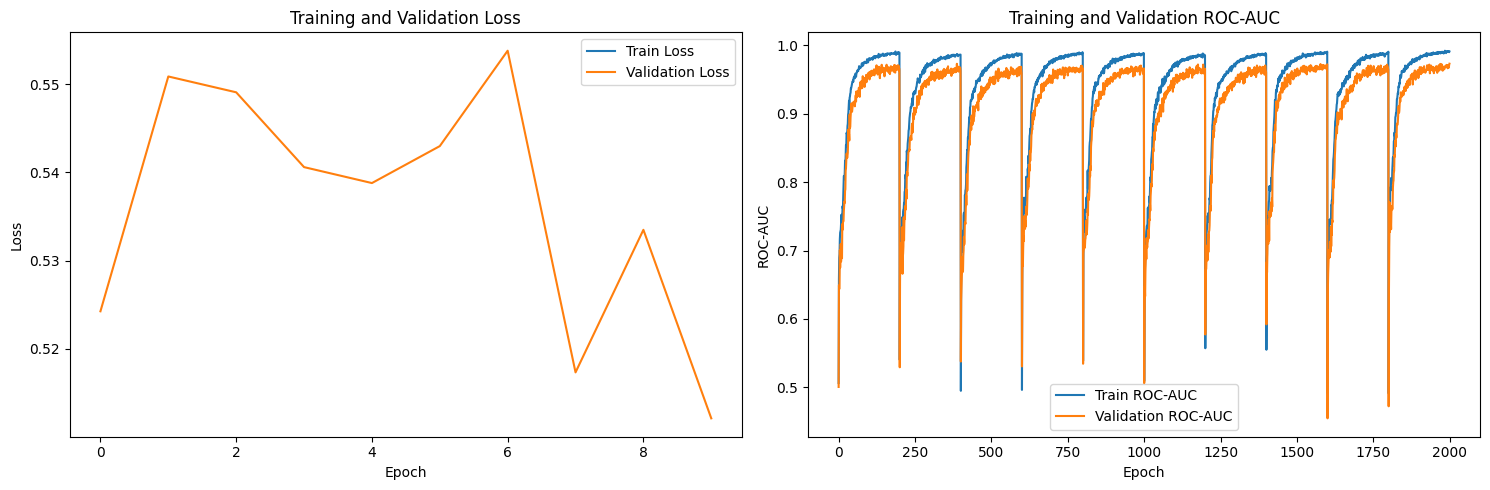

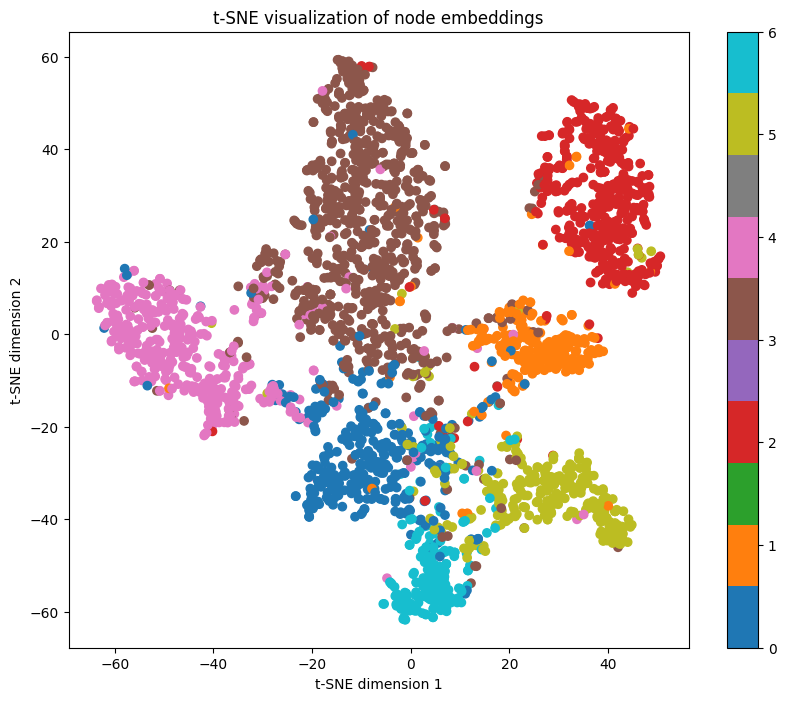

In [37]:

model = SSP(dataset)
kwargs = {
    'dataset': dataset, 
    'model': SSP(dataset), 
    'optimizer_name': 'Adam', 
    'preconditioner_name': 'KFAC', 
    'runs': 10, 
    'epochs': 200, 
    'lr': 0.01, 
    'weight_decay': 5e-4,
    'early_stopping': 0,
    'momentum': 0.9,
    'eps': 0.46415,
    'update_freq': 50,
    'gamma': None,
    'alpha': None
}
loss, acc_mean, acc_std, train_aucs, val_aucs = run_training(**kwargs)